## Deep Learning Assignment - Group 255

| Name | StudentID  | Contribution  | 
|:--|:--|--:|
| AMOGH SINGHAL | 2020SC04081 | 100% |
| ABHAY DATTARAY THAPAN | 2020SC04431 | 100% |
| AKSHIT AGRAWAL | 2020SC04956 | 100% |

Question No.1. 
<br/>
**Vision Dataset**: The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). <br/>There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). 
<br/>Please find your dataset from the link - https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
<br/>
<br/>

In [ ]:
# Run this to connect Google Drive to read files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries/Dataset (0 mark)**<br/>
Import the required libraries and the dataset (use Google Drive if required).<br/>
Check the GPU available (recommended- use free GPU provided by Google Colab).
<br/>
<br/> 

In [ ]:
# code to check if GPU is enabled or not
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('ERROR ::: GPU device not found')
print('SUCCESS ::: Found GPU at: {}'.format(device_name))

SUCCESS ::: Found GPU at: /device:GPU:0


In [ ]:
CLASSES = ['NORMAL', 'PNEUMONIA']

DIR_MAP = {
    'train' : '/content/drive/MyDrive/Colab Notebooks/chest_xray/train',
    'val' : '/content/drive/MyDrive/Colab Notebooks/chest_xray/val',
    'test' : '/content/drive/MyDrive/Colab Notebooks/chest_xray/test' 
}



In [ ]:
import os
import cv2
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


def read_img(dir_path, img_class):
  NUM_IMGS = 2

  img_path = os.path.join(dir_path, img_class)
  for i,img in enumerate(os.listdir(img_path)[:NUM_IMGS]):
    img_arr = cv2.imread(os.path.join(img_path, img), cv2.IMREAD_GRAYSCALE)
    print(f"\nShape of the image: {img_arr.shape}")
    plt.imshow(img_arr, cmap='gray')
    plt.title(f"{img_class}: img# {i}")
    plt.show()

**Data Visualization and augmentation (1 mark)**<br/>
Plot at least two samples from each class of the dataset (use matplotlib/seaborn/any other library).<br/>

Bring the train and test data in the required format.<br/>
Print the shapes of train and test data.<br/>
<br/> 


Shape of the image: (2534, 2890)


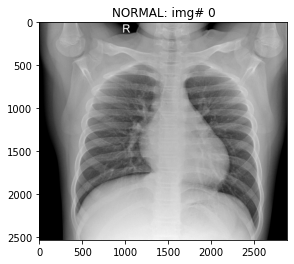


Shape of the image: (1279, 1558)


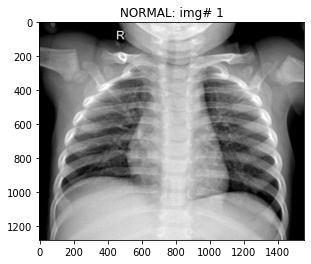

In [ ]:
read_img(DIR_MAP['train'], CLASSES[0])


Shape of the image: (1128, 1664)


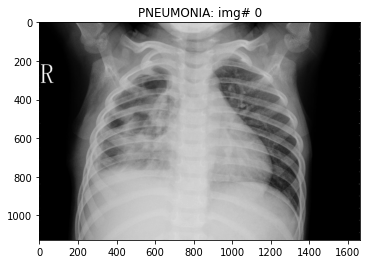


Shape of the image: (712, 1072)


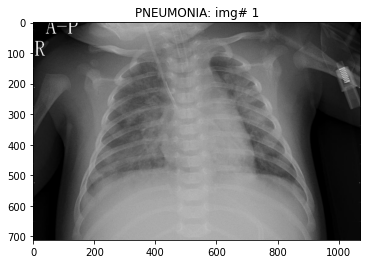

In [ ]:
read_img(DIR_MAP['val'], CLASSES[1])

In [ ]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

# height shift generator
hs_datagen = ImageDataGenerator(height_shift_range=0.5)
# rotation generator
rot_datagen = ImageDataGenerator(rotation_range=90)

normal_img = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/IM-0127-0001.jpeg'
disease_img = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'

def data_augmentation(datagen, gentype, samples):
  # prepare iterator
  it = datagen.flow(samples, batch_size=1)

  # generate samples and plot
  for i in range(9):
    
    # define subplot
    plt.subplot(330 + 1 + i)
    
    # generate batch of images
    batch = it.next()
    
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # plot raw pixel data
    plt.imshow(image)

  # show the figure
  plt.suptitle(gentype)
  plt.show()

def prepare_samples(img_path):
  # load the image
  img = load_img(img_path)

  # convert to numpy array
  data = img_to_array(img)

  # expand dimension to one sample
  samples = expand_dims(data, 0)

  return samples


* Apply rotation and height shift augmentation (rotation_range, height_shift_range)to the dataset separately.<br/> 
* Print the augmented image and the original image for each class and each augmentation.<br/>

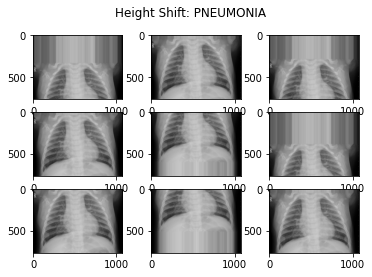

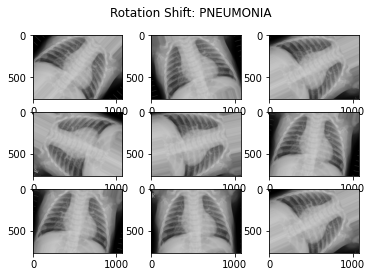

In [ ]:
samples_pneumonia = prepare_samples(disease_img)

data_augmentation(hs_datagen, 'Height Shift: PNEUMONIA', samples_pneumonia)
data_augmentation(rot_datagen, 'Rotation Shift: PNEUMONIA', samples_pneumonia)

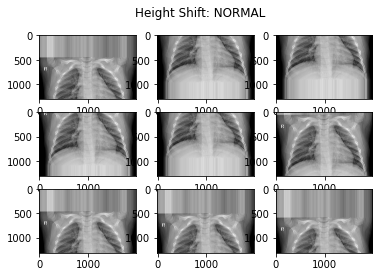

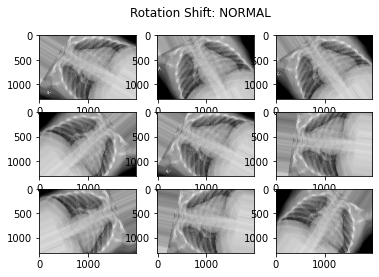

In [ ]:
samples_normal = prepare_samples(normal_img)

data_augmentation(hs_datagen, 'Height Shift: NORMAL', samples_normal)
data_augmentation(rot_datagen, 'Rotation Shift: NORMAL', samples_normal)

For data transformation, we have done the following steps
* Resized the image to (96,96) -- `done to reduce the data size`
* Normalized the pixels to be in range [0,1] -- `done to make network converge faster`
* Combined the data for both the classes and apply `random shuffling`
* Saved the data as `pickle` files

[Go to model building](#another_cell)


ELSE

Continue below to `Data Transformation`

In [ ]:
import os
import cv2
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def process_image(img_path, target_size, disp=False):
    img = Image.open(img_path)
    if disp: display(img)
    # img = ImageOps.grayscale(img)
    img = img.resize(size=target_size)
    if disp: display(img)
    img = np.ravel(img) / 255.0
    return img

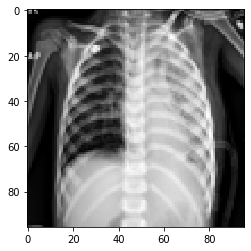

In [ ]:
row = X_train.iloc[[2]].to_numpy()
row
processed_img = process_array_to_image(row)

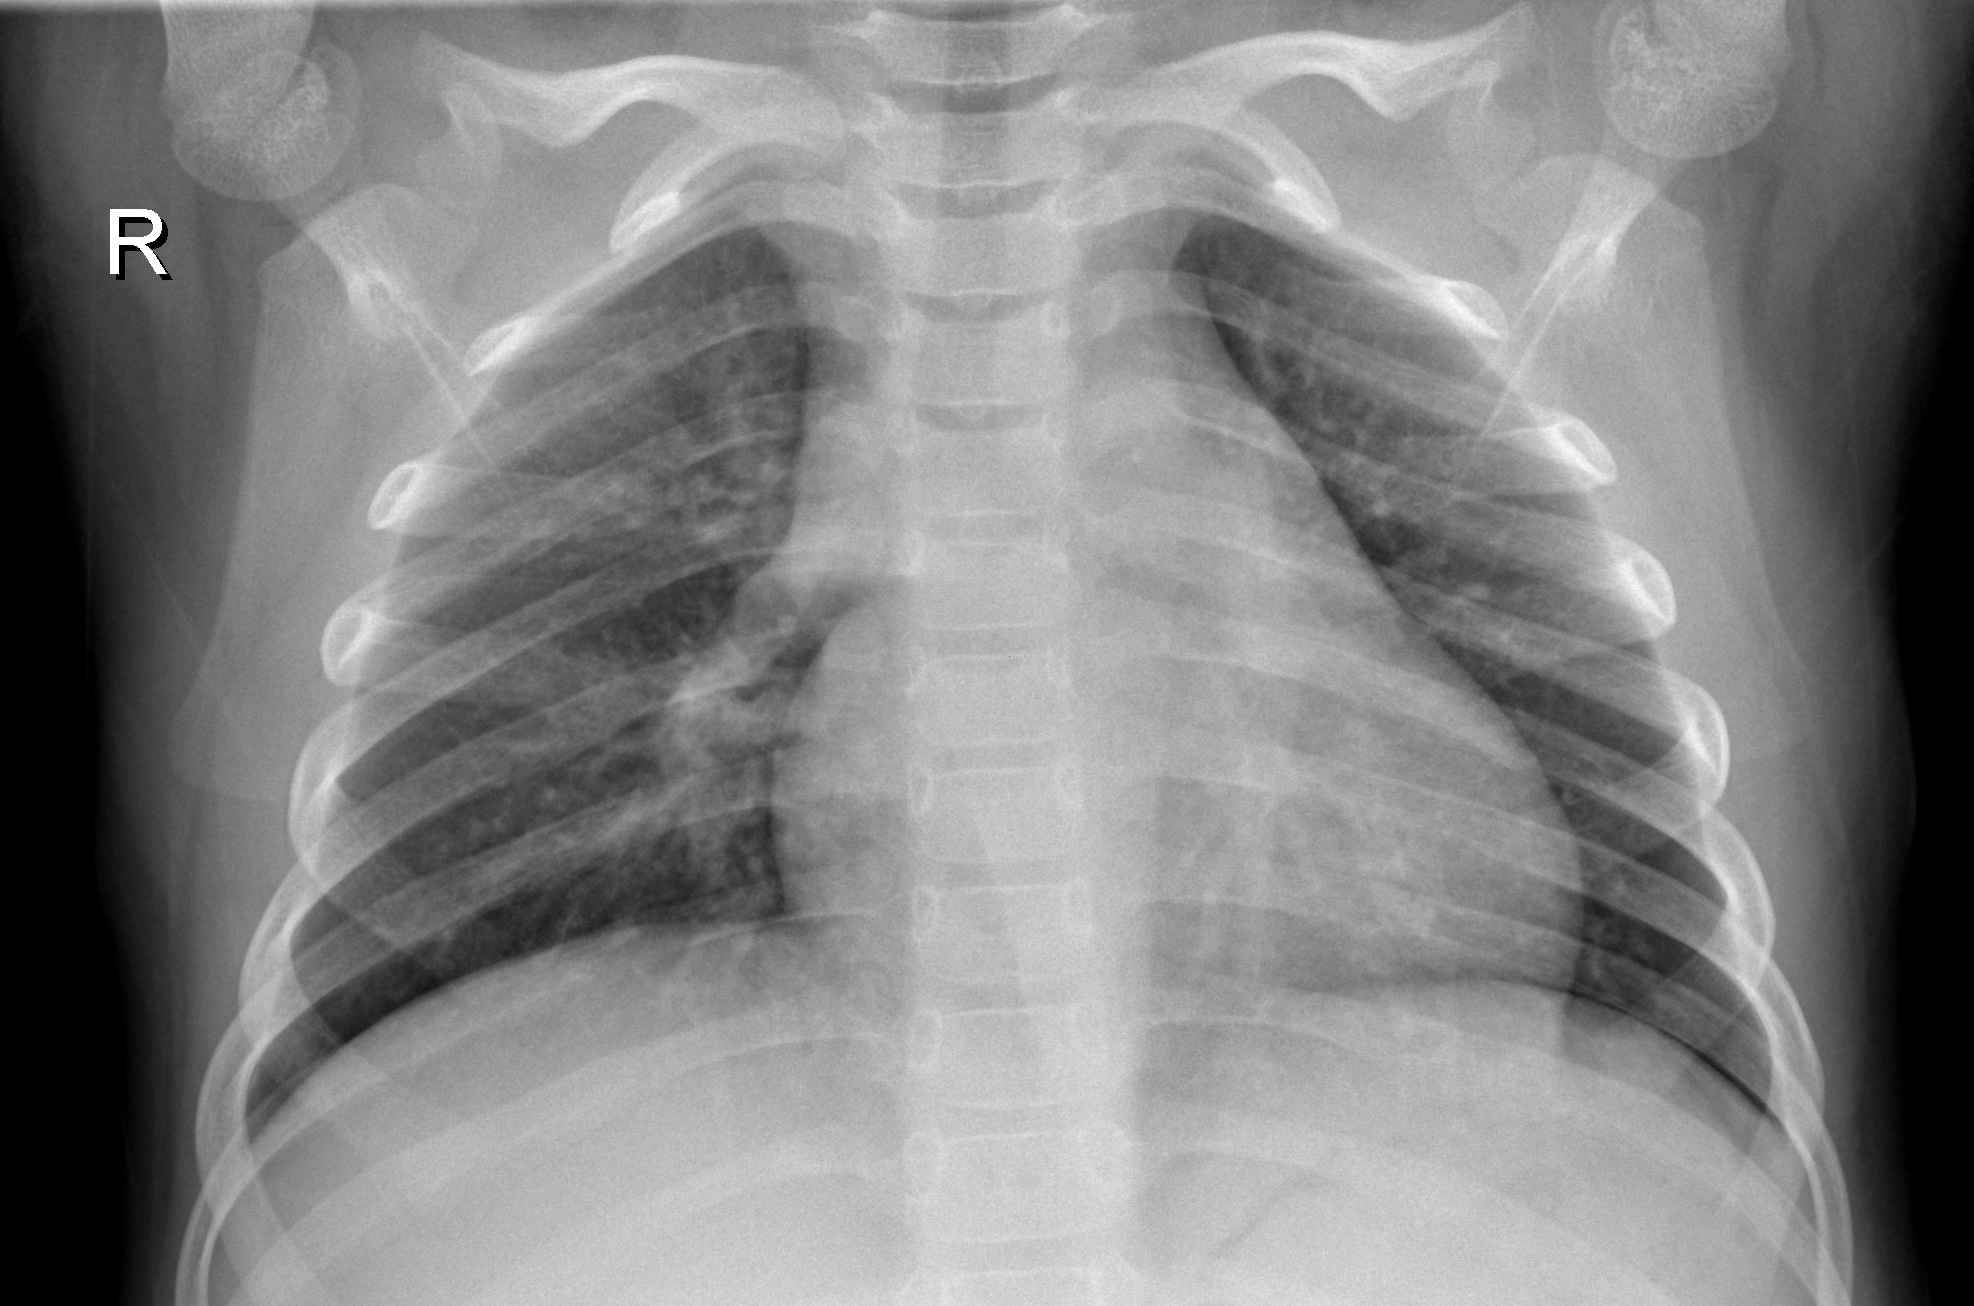

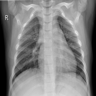

array([0.36470588, 0.40392157, 0.45490196, ..., 0.03921569, 0.        ,
       0.        ])

In [ ]:
rs_img = process_image(normal_img, (96, 96), True)
rs_img

## Process the entire dataset

#### Note: If you don't have the dataset, you can skip running these cells

* We have declared a function that will process all images in a given folder
* The function returns processed images as a Pandas DataFrame, each row is a single image as a 1-D array of pixels
* An additional column is present to display the `class` of the image

In [ ]:
def process_folder(folder):
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpeg':
            resized = process_image(img_path=str(img), target_size=(96,96))
            # print(resized)
            processed.append(resized)
           
    # Convert to pd.DataFrame
    # print(processed, len(processed))
    processed = pd.DataFrame(processed)
    # Add a class column - normal or pneumonia
    processed['class'] = folder.parts[-1]
    # print(processed.shape)
    return processed

In [ ]:
# testing the above method on NORMAL images training dataset
train_normal = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL'))
train_normal

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.184314,0.274510,0.341176,0.435294,0.533333,0.580392,0.596078,0.600000,0.588235,0.643137,...,0.227451,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
1,0.000000,0.023529,0.058824,0.078431,0.278431,0.254902,0.003922,0.000000,0.000000,0.000000,...,0.529412,0.556863,0.317647,0.043137,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
2,0.098039,0.145098,0.184314,0.203922,0.223529,0.219608,0.207843,0.211765,0.356863,0.301961,...,0.231373,0.145098,0.082353,0.011765,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
3,0.000000,0.000000,0.011765,0.062745,0.121569,0.176471,0.207843,0.227451,0.250980,0.270588,...,0.611765,0.439216,0.203922,0.074510,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
4,0.062745,0.156863,0.192157,0.196078,0.239216,0.266667,0.450980,0.454902,0.411765,0.403922,...,0.650980,0.654902,0.627451,0.564706,0.560784,0.435294,0.231373,0.031373,0.0,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,0.098039,0.192157,0.254902,0.305882,0.368627,0.400000,0.419608,0.415686,0.501961,0.619608,...,0.517647,0.325490,0.145098,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
1337,0.325490,0.309804,0.278431,0.254902,0.200000,0.200000,0.250980,0.282353,0.329412,0.435294,...,0.392157,0.270588,0.137255,0.050980,0.003922,0.000000,0.000000,0.000000,0.0,NORMAL
1338,0.000000,0.011765,0.105882,0.203922,0.301961,0.388235,0.439216,0.462745,0.478431,0.482353,...,0.545098,0.317647,0.188235,0.015686,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL
1339,0.176471,0.176471,0.184314,0.188235,0.180392,0.219608,0.235294,0.247059,0.247059,0.223529,...,0.278431,0.196078,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NORMAL


Processing the rest of datasets

In [ ]:
val_normal = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/val/NORMAL'))
test_normal = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/test/NORMAL'))

train_pnem = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/train/PNEUMONIA'))
val_pnem = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/val/PNEUMONIA'))
test_pnem = process_folder(pathlib.Path('/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA'))


The combiner utility will concatenate the datasets and save it as a pickle file
* The `dataset_type` will take the name of the dataset (training, validation, test etc.)

In [ ]:
def combiner(datasets, dataset_type):
  combined = pd.concat(datasets, axis=0)
  home_dir = "/content/"

  with open(f"{home_dir}{dataset_type}.pkl", 'wb') as f:
      pickle.dump(combined, f)

In [ ]:
print("Shape for NORMAL ::: Training | Validation | Test")
print(train_normal.shape, val_normal.shape, test_normal.shape)

print("Shape for PNEUMONIA ::: Training | Validation | Test")
print(train_pnem.shape, val_pnem.shape, test_pnem.shape)

Shape for NORMAL ::: Training | Validation | Test
(1341, 9217) (8, 9217) (234, 9217)
Shape for PNEUMONIA ::: Training | Validation | Test
(3875, 27649) (8, 9217) (390, 9217)


We will take out the first 9216 feature columns from the PNEUMONIA training set to end up with the same shape and combine it with NORMAL training set

In [ ]:
# fetching first 9216 features from pneumonia dataset for `pd.concat()` to work
df1 = train_pnem.iloc[:, :9216]
df1 = pd.concat([df1, train_pnem['class']], axis=1)
df1

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.639216,0.513725,0.419608,0.282353,0.219608,0.188235,0.184314,0.203922,0.219608,0.235294,...,0.125490,0.129412,0.129412,0.129412,0.133333,0.133333,0.137255,0.133333,0.133333,PNEUMONIA
1,0.403922,0.666667,0.564706,0.709804,0.721569,0.717647,0.733333,0.498039,0.227451,0.243137,...,0.047059,0.078431,0.086275,0.094118,0.094118,0.098039,0.098039,0.105882,0.121569,PNEUMONIA
2,0.298039,0.274510,0.274510,0.203922,0.172549,0.192157,0.203922,0.211765,0.231373,0.231373,...,0.094118,0.098039,0.101961,0.101961,0.105882,0.086275,0.133333,0.490196,0.694118,PNEUMONIA
3,0.258824,0.313725,0.352941,0.364706,0.384314,0.380392,0.560784,0.349020,0.654902,0.407843,...,0.482353,0.368627,0.141176,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
4,0.141176,0.149020,0.188235,0.200000,0.211765,0.219608,0.215686,0.247059,0.254902,0.239216,...,0.078431,0.086275,0.086275,0.090196,0.090196,0.090196,0.094118,0.129412,0.258824,PNEUMONIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3870,0.411765,0.435294,0.462745,0.478431,0.478431,0.490196,0.490196,0.509804,0.509804,0.447059,...,0.627451,0.576471,0.478431,0.529412,0.423529,0.152941,0.011765,0.000000,0.000000,PNEUMONIA
3871,0.470588,0.384314,0.411765,0.580392,0.647059,0.607843,0.588235,0.596078,0.619608,0.643137,...,0.129412,0.047059,0.000000,0.019608,0.043137,0.035294,0.027451,0.031373,0.054902,PNEUMONIA
3872,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.678431,0.600000,0.552941,0.537255,0.454902,0.247059,0.078431,0.011765,0.007843,PNEUMONIA
3873,0.003922,0.003922,0.007843,0.007843,0.003922,0.003922,0.000000,0.000000,0.000000,0.000000,...,0.423529,0.325490,0.313725,0.101961,0.023529,0.011765,0.000000,0.015686,0.019608,PNEUMONIA


In [ ]:
%%time
combiner([train_normal, df1], 'train_set')

CPU times: user 182 ms, sys: 747 ms, total: 928 ms
Wall time: 1.6 s


In [ ]:
%%time
combiner([val_normal, val_pnem], 'valid_set')

CPU times: user 3.04 ms, sys: 3.02 ms, total: 6.07 ms
Wall time: 7.2 ms


In [ ]:
%%time
combiner([test_normal, test_pnem], 'test_set')

CPU times: user 35.1 ms, sys: 49.4 ms, total: 84.5 ms
Wall time: 100 ms


<a id='another_cell'>Model Building</a>

## IMPORTANT: Dataset loading and model building starts from here

In [ ]:
import os

print(os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/chest_xray')
print(os.getcwd())

/content
/content/drive/MyDrive/Colab Notebooks/chest_xray


In [ ]:
import pandas as pd
train_data = pd.read_pickle('./train_set.pkl')
# train_data

In [ ]:
valid_data = pd.read_pickle('./valid_set.pkl')
valid_data

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.054902,0.121569,0.133333,0.160784,0.164706,0.160784,0.164706,0.156863,0.098039,0.058824,...,0.470588,0.266667,0.054902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
1,0.172549,0.313725,0.176471,0.105882,0.113725,0.094118,0.078431,0.070588,0.054902,0.062745,...,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.003922,0.000000,0.000000,NORMAL
2,0.200000,0.329412,0.388235,0.443137,0.474510,0.490196,0.509804,0.525490,0.658824,0.713725,...,0.752941,0.576471,0.321569,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
3,0.160784,0.239216,0.239216,0.360784,0.513725,0.431373,0.435294,0.431373,0.462745,0.466667,...,0.623529,0.564706,0.466667,0.325490,0.176471,0.054902,0.007843,0.019608,0.015686,NORMAL
4,0.149020,0.125490,0.050980,0.121569,0.176471,0.200000,0.227451,0.243137,0.250980,0.266667,...,0.090196,0.086275,0.094118,0.105882,0.133333,0.145098,0.145098,0.125490,0.109804,NORMAL
5,0.145098,0.086275,0.129412,0.219608,0.282353,0.356863,0.419608,0.450980,0.466667,0.474510,...,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
6,0.192157,0.356863,0.231373,0.027451,0.039216,0.031373,0.015686,0.003922,0.000000,0.019608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
7,0.000000,0.003922,0.019608,0.039216,0.058824,0.074510,0.090196,0.098039,0.113725,0.121569,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
0,0.000000,0.003922,0.011765,0.019608,0.043137,0.066667,0.086275,0.113725,0.145098,0.172549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
1,0.007843,0.003922,0.003922,0.000000,0.101961,0.415686,0.035294,0.015686,0.031373,0.019608,...,0.000000,0.011765,0.015686,0.027451,0.027451,0.031373,0.031373,0.031373,0.031373,PNEUMONIA


In [ ]:
test_data = pd.read_pickle('./test_set.pkl')
# test_data

### Additional processing
* Datasets now contain images of normal first, followed by images of pneumonia
* We want to shuffle those datasets, so a neural network goes through the images in a random order:

In [ ]:
train_data = shuffle(train_data).reset_index(drop=True)
valid_data = shuffle(valid_data).reset_index(drop=True)
test_data = shuffle(test_data).reset_index(drop=True)

In [ ]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.337255,0.345098,0.372549,0.419608,0.450980,0.458824,0.454902,0.427451,0.400000,0.380392,...,0.588235,0.568627,0.580392,0.494118,0.239216,0.090196,0.007843,0.000000,0.000000,PNEUMONIA
1,0.325490,0.345098,0.223529,0.180392,0.211765,0.223529,0.239216,0.258824,0.270588,0.376471,...,0.035294,0.058824,0.070588,0.078431,0.082353,0.086275,0.098039,0.105882,0.211765,PNEUMONIA
2,0.164706,0.207843,0.239216,0.235294,0.411765,0.509804,0.431373,0.431373,0.419608,0.427451,...,0.533333,0.670588,0.611765,0.266667,0.117647,0.011765,0.000000,0.000000,0.000000,NORMAL
3,0.003922,0.000000,0.423529,0.168627,0.466667,0.137255,0.011765,0.047059,0.078431,0.129412,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
4,0.000000,0.000000,0.000000,0.000000,0.027451,0.101961,0.192157,0.231373,0.235294,0.227451,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,0.572549,0.470588,0.376471,0.294118,0.282353,0.227451,0.298039,0.325490,0.286275,0.305882,...,0.807843,0.764706,0.466667,0.325490,0.250980,0.101961,0.047059,0.074510,0.078431,PNEUMONIA
5212,0.050980,0.078431,0.101961,0.137255,0.298039,0.337255,0.333333,0.337255,0.352941,0.403922,...,0.368627,0.160784,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
5213,0.000000,0.000000,0.000000,0.000000,0.019608,0.043137,0.074510,0.098039,0.113725,0.133333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
5214,0.313725,0.313725,0.313725,0.278431,0.278431,0.278431,0.231373,0.231373,0.231373,0.215686,...,0.266667,0.266667,0.266667,0.164706,0.164706,0.164706,0.113725,0.113725,0.113725,PNEUMONIA


In [ ]:
valid_data

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.145098,0.086275,0.129412,0.219608,0.282353,0.356863,0.419608,0.450980,0.466667,0.474510,...,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
1,0.200000,0.329412,0.388235,0.443137,0.474510,0.490196,0.509804,0.525490,0.658824,0.713725,...,0.752941,0.576471,0.321569,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
2,0.160784,0.239216,0.239216,0.360784,0.513725,0.431373,0.435294,0.431373,0.462745,0.466667,...,0.623529,0.564706,0.466667,0.325490,0.176471,0.054902,0.007843,0.019608,0.015686,NORMAL
3,0.000000,0.003922,0.011765,0.019608,0.043137,0.066667,0.086275,0.113725,0.145098,0.172549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
4,0.000000,0.000000,0.000000,0.000000,0.035294,0.396078,0.192157,0.035294,0.058824,0.078431,...,0.039216,0.039216,0.039216,0.105882,0.231373,0.666667,0.423529,0.105882,0.062745,PNEUMONIA
5,0.070588,0.078431,0.105882,0.133333,0.145098,0.372549,0.411765,0.141176,0.160784,0.160784,...,0.364706,0.219608,0.149020,0.094118,0.078431,0.007843,0.000000,0.007843,0.054902,PNEUMONIA
6,0.149020,0.125490,0.050980,0.121569,0.176471,0.200000,0.227451,0.243137,0.250980,0.266667,...,0.090196,0.086275,0.094118,0.105882,0.133333,0.145098,0.145098,0.125490,0.109804,NORMAL
7,0.243137,0.243137,0.239216,0.243137,0.411765,0.380392,0.231373,0.250980,0.227451,0.474510,...,0.000000,0.000000,0.000000,0.000000,0.003922,0.003922,0.007843,0.027451,0.035294,PNEUMONIA
8,0.054902,0.121569,0.133333,0.160784,0.164706,0.160784,0.164706,0.156863,0.098039,0.058824,...,0.470588,0.266667,0.054902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NORMAL
9,0.172549,0.313725,0.176471,0.105882,0.113725,0.094118,0.078431,0.070588,0.054902,0.062745,...,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.003922,0.000000,0.000000,NORMAL


In [ ]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,9207,9208,9209,9210,9211,9212,9213,9214,9215,class
0,0.000000,0.000000,0.000000,0.066667,0.121569,0.121569,0.117647,0.121569,0.121569,0.109804,...,0.113725,0.129412,0.129412,0.129412,0.137255,0.074510,0.000000,0.000000,0.000000,NORMAL
1,0.039216,0.090196,0.149020,0.235294,0.286275,0.341176,0.384314,0.384314,0.403922,0.407843,...,0.490196,0.317647,0.176471,0.090196,0.015686,0.000000,0.000000,0.000000,0.000000,NORMAL
2,0.074510,0.133333,0.152941,0.188235,0.219608,0.262745,0.258824,0.247059,0.239216,0.231373,...,0.470588,0.231373,0.196078,0.149020,0.078431,0.105882,0.113725,0.117647,0.121569,NORMAL
3,0.298039,0.513725,0.615686,0.203922,0.388235,0.474510,0.466667,0.643137,0.588235,0.211765,...,0.211765,0.074510,0.023529,0.050980,0.066667,0.066667,0.074510,0.070588,0.070588,PNEUMONIA
4,0.168627,0.180392,0.176471,0.180392,0.270588,0.184314,0.196078,0.188235,0.141176,0.152941,...,0.050980,0.082353,0.098039,0.101961,0.105882,0.109804,0.113725,0.117647,0.113725,PNEUMONIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0.309804,0.333333,0.415686,0.560784,0.552941,0.549020,0.556863,0.580392,0.607843,0.517647,...,0.580392,0.592157,0.529412,0.262745,0.082353,0.011765,0.000000,0.000000,0.027451,PNEUMONIA
620,0.113725,0.094118,0.490196,0.278431,0.509804,0.309804,0.192157,0.211765,0.231373,0.274510,...,0.196078,0.090196,0.058824,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,PNEUMONIA
621,0.568627,0.541176,0.631373,0.572549,0.588235,0.556863,0.603922,0.545098,0.521569,0.517647,...,0.592157,0.517647,0.486275,0.392157,0.298039,0.188235,0.035294,0.000000,0.000000,PNEUMONIA
622,0.000000,0.000000,0.000000,0.196078,0.427451,0.396078,0.290196,0.196078,0.176471,0.192157,...,0.164706,0.054902,0.019608,0.023529,0.050980,0.043137,0.000000,0.000000,0.000000,NORMAL


### Data distribution - Prepared datasets

In [ ]:
print(train_data['class'].value_counts(normalize=True)*100.0, '\n')
print(valid_data['class'].value_counts(normalize=True)*100.0, '\n')
print(test_data['class'].value_counts(normalize=True)*100.0)

PNEUMONIA    74.290644
NORMAL       25.709356
Name: class, dtype: float64 

PNEUMONIA    50.0
NORMAL       50.0
Name: class, dtype: float64 

PNEUMONIA    62.5
NORMAL       37.5
Name: class, dtype: float64


* Seperating features and labels

In [ ]:
X_train = train_data.drop('class', axis=1)
y_train = train_data['class']

X_valid = valid_data.drop('class', axis=1)
y_valid = valid_data['class']

X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

In [ ]:
# factorize will encode the categories to numeric
y_train.factorize()

(array([0, 0, 0, ..., 0, 1, 1]),
 Index(['PNEUMONIA', 'NORMAL'], dtype='object'))

In [ ]:
# changing the encoding of target to one-hot numeric to support softmax activation
# this is done to tackle the class imbalance observed above
y_train = tf.keras.utils.to_categorical(y_train.factorize()[0], num_classes=2)
y_valid = tf.keras.utils.to_categorical(y_valid.factorize()[0], num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test.factorize()[0], num_classes=2)

In [ ]:
# classes are now encoded as [1,0] for PNEUMONIA and [0,1] for NORMAL
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)


### Model Building (0.2 x 5 = 1 mark)<br/>
* Sequential Model layers- Use AT LEAST 4 hidden layers with appropriate input for each. 
* Choose the best number for hidden units and give reasons.
* Add L2 regularization to all the layers.
* Add one layer of dropout at the appropriate position and give reasons.
* Choose the appropriate activation function for all the layers.
* Print the model summary.

In [ ]:
from tensorflow import keras, random
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras.metrics import BinaryAccuracy

random.set_seed(42)

model = Sequential()

# 8192 is chosen since it the smallest power of 2 avaialble near 9216(input shape)
model.add(Dense(8192, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# a dropout of 50% is used to decrease the overfitting in the network
model.add(Dropout(0.5))

# successive hidden layers are powers of 2, with L2 regularization
# L2 regularization is used to tackle overfitting and it is also computationally faster
# TanH is used as activation as per instruction, but it was observed that ReLU will perform better
# since we are performing image classification using a simple neural network
model.add(Dense(2048, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(512, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(128, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(32, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# output layer -- 2 nodes to facilitate encoded outputs [1,0] and [0,1]
# softmax is used as activation becuase we have multi-class output
model.add(Dense(2, activation='softmax'))

**Model Compilation (0.25 mark)**
<br/>
* Compile the model with the appropriate loss function.
<br/>
* Use an appropriate optimizer. 
<br/>
* Give reasons for the choice of learning rate and its value.
<br/>
* Use accuracy as a metric.

In [ ]:
EPOCHS = 500
LEARNING_RATE = 0.001
opt = adam_v2.Adam(learning_rate=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS)

# Adam is as an optimizer becuase it is faster to train and requires few paramters for tuning
# Accuracy is chosen as metric as instructed

model.compile(
    loss=categorical_crossentropy,
    optimizer=opt,
    metrics=[BinaryAccuracy(name='accuracy')]
)

print('\nModel Summary')
model.build(input_shape=X_train.shape)
print(model.summary())


Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (5216, 8192)              75505664  
                                                                 
 dropout (Dropout)           (5216, 8192)              0         
                                                                 
 dense_1 (Dense)             (5216, 2048)              16779264  
                                                                 
 dense_2 (Dense)             (5216, 512)               1049088   
                                                                 
 dense_3 (Dense)             (5216, 128)               65664     
                                                                 
 dense_4 (Dense)             (5216, 32)                4128      
                                                                 
 dense_5 (Dense)             (5216, 2)   

**Model Training (0.5 + 0.25 = 0.75 mark)**
<br/>
* Train the model for an appropriate number of epochs. 
<br/>
* Print the train and validation accuracy and loss for each epoch. 
<br/>
* Use the appropriate batch size.
<br/>
* Plot the loss and accuracy history graphs for both train and validation set. 
<br/>
* Print the total time taken for training.

In [ ]:
%%time
# takes approximately 6 mins to train on the Google collab GPU
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/500
41/41 [==============================] - 6s 55ms/step - loss: 44.4697 - accuracy: 0.7377 - val_loss: 6.9306 - val_accuracy: 0.5000
Epoch 2/500
41/41 [==============================] - 2s 49ms/step - loss: 3.3882 - accuracy: 0.7431 - val_loss: 2.0147 - val_accuracy: 0.5000
Epoch 3/500
41/41 [==============================] - 2s 49ms/step - loss: 1.5461 - accuracy: 0.7312 - val_loss: 1.5968 - val_accuracy: 0.5000
Epoch 4/500
41/41 [==============================] - 2s 49ms/step - loss: 2.7700 - accuracy: 0.7370 - val_loss: 1.9023 - val_accuracy: 0.5000
Epoch 5/500
41/41 [==============================] - 2s 49ms/step - loss: 1.0910 - accuracy: 0.7439 - val_loss: 1.2472 - val_accuracy: 0.5000
Epoch 6/500
41/41 [==============================] - 2s 48ms/step - loss: 0.7693 - accuracy: 0.7429 - val_loss: 0.9659 - val_accuracy: 0.5000
Epoch 7/500
41/41 [==============================] - 2s 49ms/step - loss: 0.6743 - accuracy: 0.7433 - val_loss: 0.9690 - val_accuracy: 0.5000
Epoch

## Plotting Loss and Accuracy Curves

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

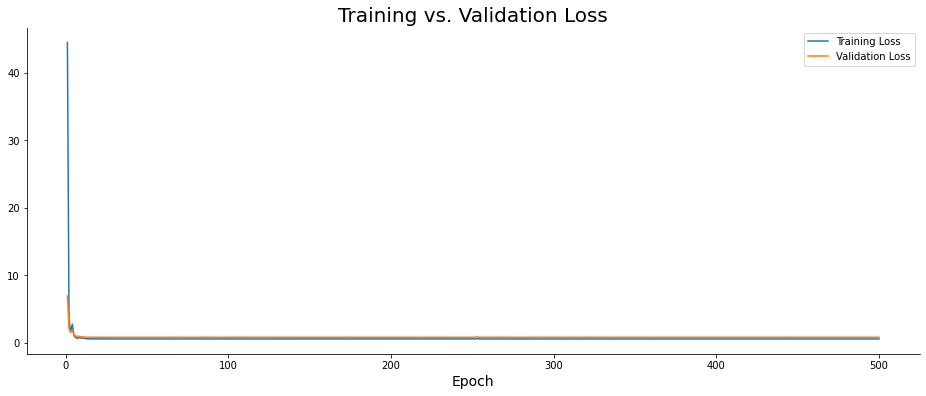

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

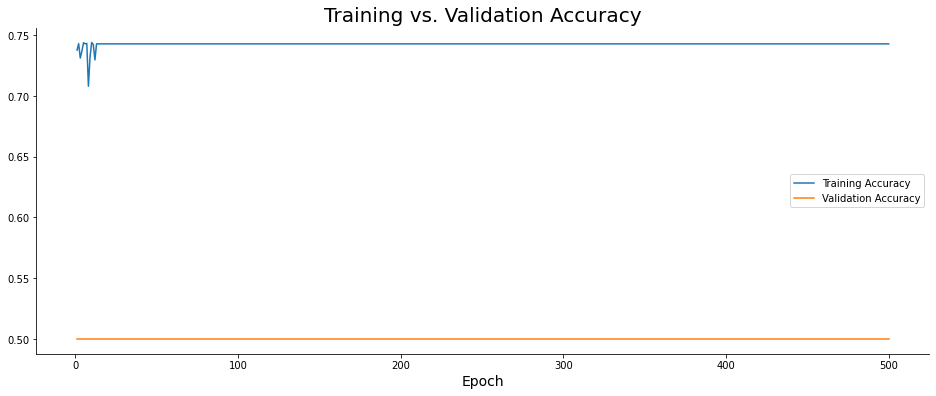

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

**Model Evaluation (0.5 + 0.5 = 1 mark)**
<br/>
* Print the final train and validation loss and accuracy. <br/>
* Print confusion matrix and classification report for the validation dataset. <br/>
* Analyse and report the best and worst performing class.
<br/>
* Print the two most incorrectly classified images for each class in the test dataset.
<br/><br/> 

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

print("Running predictions on validation set...")
predictions = (model.predict(X_valid) > 0.5).astype(int)

print('\n Classification Report\n', classification_report(y_valid, predictions))
conf_mat = confusion_matrix(y_valid.argmax(axis=1),predictions.argmax(axis=1))

print('\n Confusion Matrix\n', conf_mat)

Running predictions on validation set...

 Classification Report
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         8

   micro avg       0.50      0.50      0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16
 samples avg       0.50      0.50      0.50        16


 Confusion Matrix
 [[8 0]
 [8 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


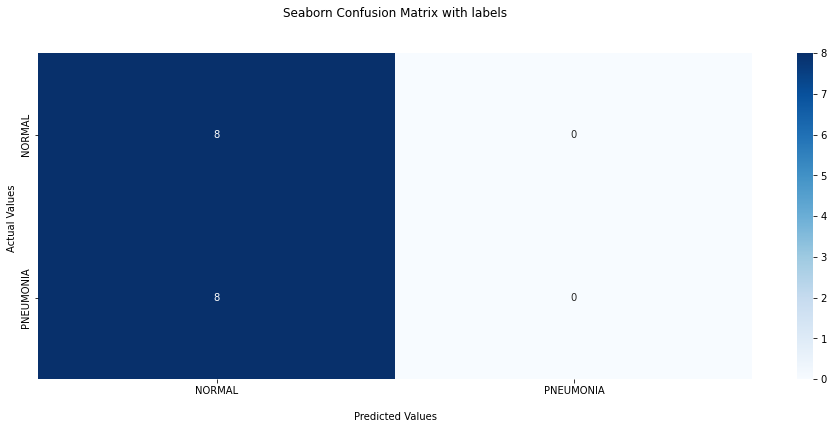

In [ ]:
import seaborn as sns

ax = sns.heatmap(conf_mat, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
CLASSES = ['NORMAL', 'PNEUMONIA']

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(type (X_valid))
print(type (y_valid))
print(type (predictions))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
X_valid_final = pd.concat([X_valid, pd.DataFrame(y_valid, columns=['true0', 'true1']), pd.DataFrame(predictions, columns=['pred0', 'pred1'])], axis=1)
X_valid_final

,0,1,2,3,4,5,6,7,8,9,...,9210,9211,9212,9213,9214,9215,true0,true1,pred0,pred1
0,0.145098,0.086275,0.129412,0.219608,0.282353,0.356863,0.419608,0.450980,0.466667,0.474510,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0
1,0.200000,0.329412,0.388235,0.443137,0.474510,0.490196,0.509804,0.525490,0.658824,0.713725,...,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0
2,0.160784,0.239216,0.239216,0.360784,0.513725,0.431373,0.435294,0.431373,0.462745,0.466667,...,0.325490,0.176471,0.054902,0.007843,0.019608,0.015686,1.0,0.0,1,0
3,0.000000,0.003922,0.011765,0.019608,0.043137,0.066667,0.086275,0.113725,0.145098,0.172549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1,0
4,0.000000,0.000000,0.000000,0.000000,0.035294,0.396078,0.192157,0.035294,0.058824,0.078431,...,0.105882,0.231373,0.666667,0.423529,0.105882,0.062745,0.0,1.0,1,0
5,0.070588,0.078431,0.105882,0.133333,0.145098,0.372549,0.411765,0.141176,0.160784,0.160784,...,0.094118,0.078431,0.007843,0.000000,0.007843,0.054902,0.0,1.0,1,0
6,0.149020,0.125490,0.050980,0.121569,0.176471,0.200000,0.227451,0.243137,0.250980,0.266667,...,0.105882,0.133333,0.145098,0.145098,0.125490,0.109804,1.0,0.0,1,0
7,0.243137,0.243137,0.239216,0.243137,0.411765,0.380392,0.231373,0.250980,0.227451,0.474510,...,0.000000,0.003922,0.003922,0.007843,0.027451,0.035294,0.0,1.0,1,0
8,0.054902,0.121569,0.133333,0.160784,0.164706,0.160784,0.164706,0.156863,0.098039,0.058824,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0
9,0.172549,0.313725,0.176471,0.105882,0.113725,0.094118,0.078431,0.070588,0.054902,0.062745,...,0.000000,0.000000,0.000000,0.003922,0.000000,0.000000,1.0,0.0,1,0


In [ ]:
miss_classifier = X_valid_final[X_valid_final['pred0'] != X_valid_final['true0']]
np_miss = miss_classifier.iloc[:, 0:9216].to_numpy()
np_miss
len(np_miss)

8

Saving the model and metrics info
* The model file can be utilised to make a API service
* The history file can be utilised for monitoring data drift and model drift

In [ ]:
import json

model.save('pneumonia-detect.h5')

with open('pneumonia-detect-history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
from matplotlib import pyplot as plt

def process_array_to_image(np_arr, target_size=(96,96)):
    orig_arr = np_arr * 255.0
    int_arr = orig_arr.astype(int)
    img = int_arr.reshape(target_size)
    plt.imshow(img, interpolation='nearest', cmap='gray')
    plt.show()
    return img

Displaying Miss-classified images. 

[0.         0.00392157 0.01176471 ... 0.         0.         0.        ]


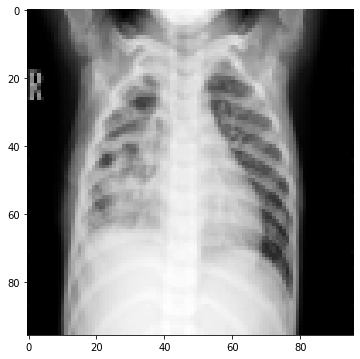

[0.         0.         0.         ... 0.42352941 0.10588235 0.0627451 ]


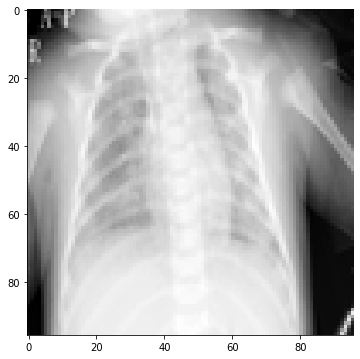

[0.07058824 0.07843137 0.10588235 ... 0.         0.00784314 0.05490196]


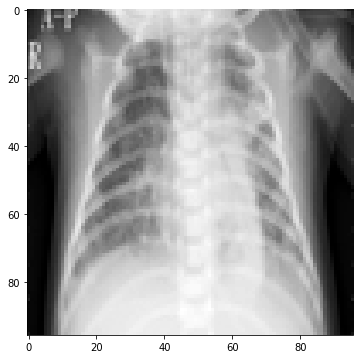

[0.24313725 0.24313725 0.23921569 ... 0.00784314 0.02745098 0.03529412]


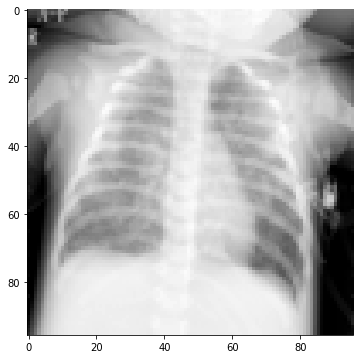

[0.         0.01960784 0.06666667 ... 0.00784314 0.00784314 0.00784314]


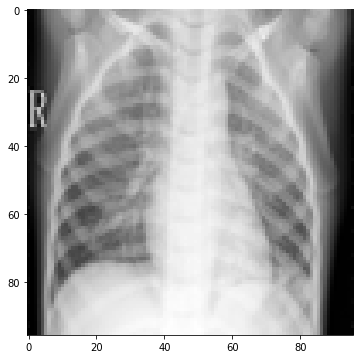

[0.         0.02745098 0.09803922 ... 0.00392157 0.00784314 0.00784314]


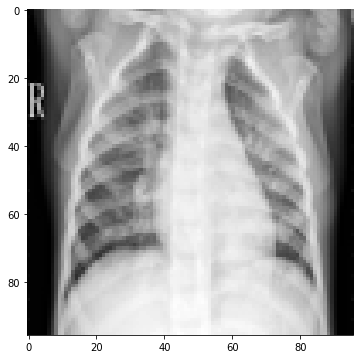

[0.32941176 0.31764706 0.47058824 ... 0.         0.         0.        ]


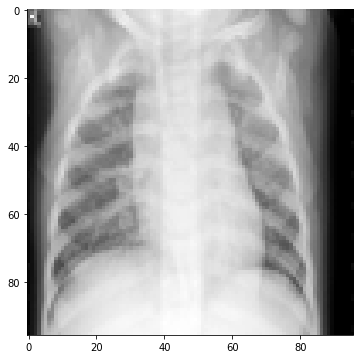

[0.00784314 0.00392157 0.00392157 ... 0.03137255 0.03137255 0.03137255]


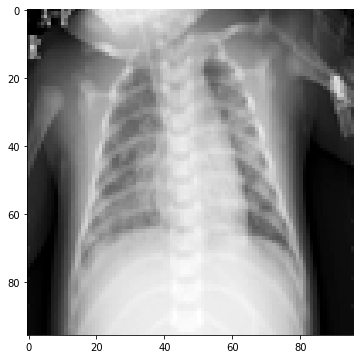

In [ ]:
for i in np_miss:
  print(i)
  process_array_to_image(i)

**Hyperparameter Tuning**
* Build two more additional models by changing the following hyperparameters ONE at a time. 
* Write the code for Model Building, Model Compilation, Model Training and Model Evaluation as given in the instructions above for each additional model. (1 + 1 = 2 marks)

* Optimiser: Use a different optimizer with the appropriate LR value.
Network Depth: Change the number of hidden layers and hidden units for each layer.

In [ ]:
from tensorflow import keras, random
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras.metrics import BinaryAccuracy

random.set_seed(42)

model1 = Sequential()

# 8192 is chosen since it the smallest power of 2 avaialble near 9216(input shape)
model1.add(Dense(1000, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# a dropout of 50% is used to decrease the overfitting in the network
model1.add(Dropout(0.5))

# successive hidden layers are multiple of 10, with L2 regularization
# L2 regularization is used to tackle overfitting and it is also computationally faster
# TanH is used as activation as per instruction, but it was observed that ReLU will perform better
# since we are performing image classification using a simple neural network
model1.add(Dense(1000, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dense(500, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dense(100, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dense(50, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(Dense(10, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# output layer -- 2 nodes to facilitate encoded outputs [1,0] and [0,1]
# softmax is used as activation becuase we have multi-class output
model1.add(Dense(2, activation='softmax'))

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.001
opt = adam_v2.Adam(learning_rate=LEARNING_RATE, decay=LEARNING_RATE/EPOCHS)

# Adam is as an optimizer becuase it is faster to train and requires few paramters for tuning
# Accuracy is chosen as metric as instructed

model1.compile(
    loss=categorical_crossentropy,
    optimizer=opt,
    metrics=[BinaryAccuracy(name='accuracy')]
)

print('\nModel Summary')
model1.build(input_shape=X_train.shape)
print(model1.summary())


Model Summary
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (5216, 1000)              9217000   
                                                                 
 dropout_3 (Dropout)         (5216, 1000)              0         
                                                                 
 dense_19 (Dense)            (5216, 1000)              1001000   
                                                                 
 dense_20 (Dense)            (5216, 500)               500500    
                                                                 
 dense_21 (Dense)            (5216, 100)               50100     
                                                                 
 dense_22 (Dense)            (5216, 50)                5050      
                                                                 
 dense_23 (Dense)            (5216, 20)

In [ ]:
%%time
# takes approximately 6 mins to train on the Google collab GPU
history = model1.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/100
41/41 [==============================] - 2s 20ms/step - loss: 20.1398 - accuracy: 0.7285 - val_loss: 7.5172 - val_accuracy: 0.5000
Epoch 2/100
41/41 [==============================] - 0s 12ms/step - loss: 3.9163 - accuracy: 0.7465 - val_loss: 2.5801 - val_accuracy: 0.5000
Epoch 3/100
41/41 [==============================] - 0s 12ms/step - loss: 1.7319 - accuracy: 0.7241 - val_loss: 1.6470 - val_accuracy: 0.5000
Epoch 4/100
41/41 [==============================] - 0s 11ms/step - loss: 1.1100 - accuracy: 0.7370 - val_loss: 1.2283 - val_accuracy: 0.5000
Epoch 5/100
41/41 [==============================] - 0s 12ms/step - loss: 0.9175 - accuracy: 0.7456 - val_loss: 1.2595 - val_accuracy: 0.5000
Epoch 6/100
41/41 [==============================] - 0s 11ms/step - loss: 0.8818 - accuracy: 0.7421 - val_loss: 1.0954 - val_accuracy: 0.5000
Epoch 7/100
41/41 [==============================] - 0s 12ms/step - loss: 0.7564 - accuracy: 0.7464 - val_loss: 1.1710 - val_accuracy: 0.5000
Epoch

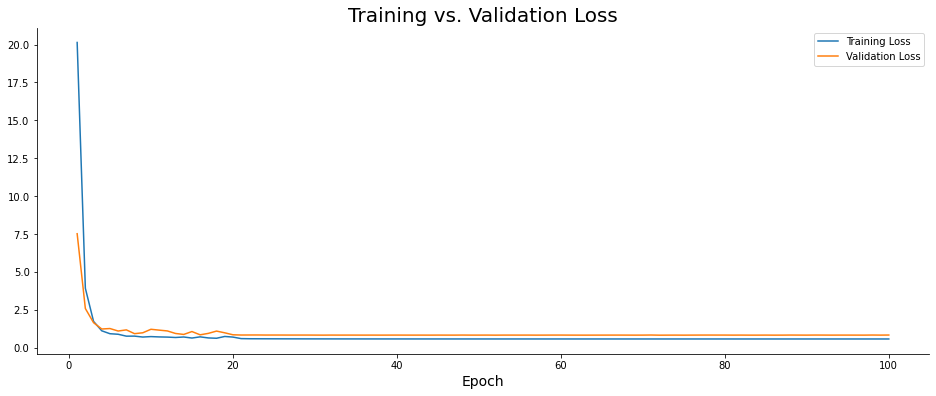

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

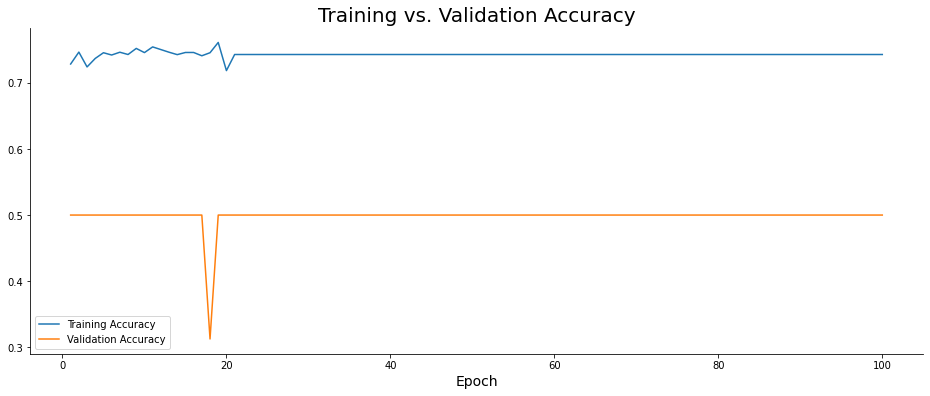

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

**Model Evaluation (0.5 + 0.5 = 1 mark)**
<br/>
* Print the final train and validation loss and accuracy. <br/>
* Print confusion matrix and classification report for the validation dataset. <br/>
* Analyse and report the best and worst performing class.
<br/>
* Print the two most incorrectly classified images for each class in the test dataset.
<br/><br/> 

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

print("Running predictions on validation set...")
predictions = (model1.predict(X_valid) > 0.5).astype(int)

print('\n Classification Report\n', classification_report(y_valid, predictions))
conf_mat1 = confusion_matrix(y_valid.argmax(axis=1),predictions.argmax(axis=1))

print('\n Confusion Matrix\n', conf_mat1)

Running predictions on validation set...

 Classification Report
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         8
           1       0.00      0.00      0.00         8

   micro avg       0.50      0.50      0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16
 samples avg       0.50      0.50      0.50        16


 Confusion Matrix
 [[8 0]
 [8 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


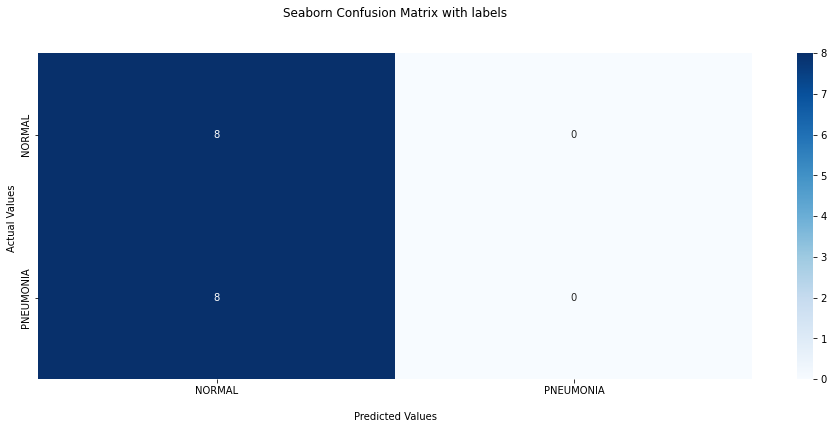

In [ ]:
import seaborn as sns

ax = sns.heatmap(conf_mat1, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
CLASSES = ['NORMAL', 'PNEUMONIA']

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from tensorflow import keras, random
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras.metrics import BinaryAccuracy

random.set_seed(42)

model2 = Sequential()

# 8192 is chosen since it the smallest power of 2 avaialble near 9216(input shape)
model2.add(Dense(1000, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# a dropout of 50% is used to decrease the overfitting in the network
model2.add(Dropout(0.5))

# successive hidden layers are multiple of 50, with L2 regularization
# L2 regularization is used to tackle overfitting and it is also computationally faster
# TanH is used as activation as per instruction, but it was observed that ReLU will perform better
# since we are performing image classification using a simple neural network
model2.add(Dense(1000, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(Dense(500, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

# output layer -- 2 nodes to facilitate encoded outputs [1,0] and [0,1]
# softmax is used as activation becuase we have multi-class output
model2.add(Dense(2, activation='softmax'))

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.001
opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.0, nesterov=False, name="SGD")

# Adam is as an optimizer becuase it is faster to train and requires few paramters for tuning
# Accuracy is chosen as metric as instructed

model2.compile(
    loss=categorical_crossentropy,
    optimizer=opt,
    metrics=[BinaryAccuracy(name='accuracy')]
)

print('\nModel Summary')
model2.build(input_shape=X_train.shape)
print(model2.summary())


Model Summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (5216, 1000)              9217000   
                                                                 
 dropout_2 (Dropout)         (5216, 1000)              0         
                                                                 
 dense_13 (Dense)            (5216, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (5216, 500)               500500    
                                                                 
 dense_15 (Dense)            (5216, 100)               50100     
                                                                 
 dense_16 (Dense)            (5216, 50)                5050      
                                                                 
 dense_17 (Dense)            (5216, 2) 

In [ ]:
%%time
# takes approximately 6 mins to train on the Google collab GPU
history = model2.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

Epoch 1/100
41/41 [==============================] - 1s 17ms/step - loss: 37.5641 - accuracy: 0.7410 - val_loss: 37.7827 - val_accuracy: 0.5000
Epoch 2/100
41/41 [==============================] - 0s 10ms/step - loss: 37.4860 - accuracy: 0.7429 - val_loss: 37.7579 - val_accuracy: 0.5000
Epoch 3/100
41/41 [==============================] - 0s 10ms/step - loss: 37.4079 - accuracy: 0.7427 - val_loss: 37.7447 - val_accuracy: 0.5000
Epoch 4/100
41/41 [==============================] - 0s 10ms/step - loss: 37.3323 - accuracy: 0.7448 - val_loss: 37.7262 - val_accuracy: 0.5000
Epoch 5/100
41/41 [==============================] - 0s 10ms/step - loss: 37.2481 - accuracy: 0.7496 - val_loss: 37.7172 - val_accuracy: 0.5000
Epoch 6/100
41/41 [==============================] - 0s 10ms/step - loss: 37.1646 - accuracy: 0.7586 - val_loss: 37.7222 - val_accuracy: 0.4375
Epoch 7/100
41/41 [==============================] - 0s 10ms/step - loss: 37.0771 - accuracy: 0.7820 - val_loss: 37.7429 - val_accuracy:

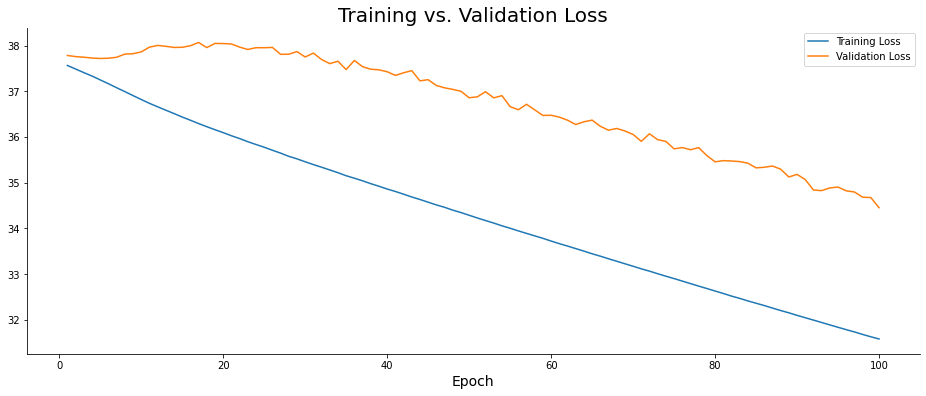

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'], label='Training Loss')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

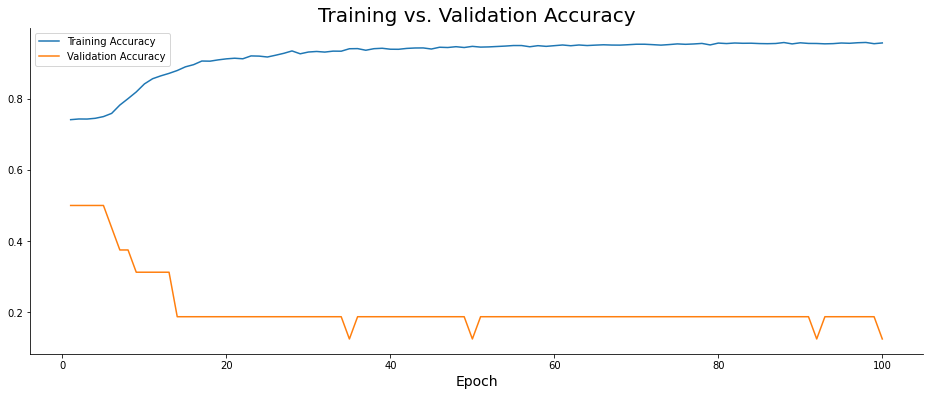

In [ ]:
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

**Model Evaluation (0.5 + 0.5 = 1 mark)**
<br/>
* Print the final train and validation loss and accuracy. <br/>
* Print confusion matrix and classification report for the validation dataset. <br/>
* Analyse and report the best and worst performing class.
<br/>
* Print the two most incorrectly classified images for each class in the test dataset.
<br/><br/> 

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

print("Running predictions on validation set...")
predictions = (model2.predict(X_valid) > 0.5).astype(int)

print('\n Classification Report\n', classification_report(y_valid, predictions))
conf_mat2 = confusion_matrix(y_valid.argmax(axis=1),predictions.argmax(axis=1))

print('\n Confusion Matrix\n', conf_mat2)

Running predictions on validation set...

 Classification Report
               precision    recall  f1-score   support

           0       0.20      0.25      0.22         8
           1       0.00      0.00      0.00         8

   micro avg       0.12      0.12      0.12        16
   macro avg       0.10      0.12      0.11        16
weighted avg       0.10      0.12      0.11        16
 samples avg       0.12      0.12      0.12        16


 Confusion Matrix
 [[2 6]
 [8 0]]


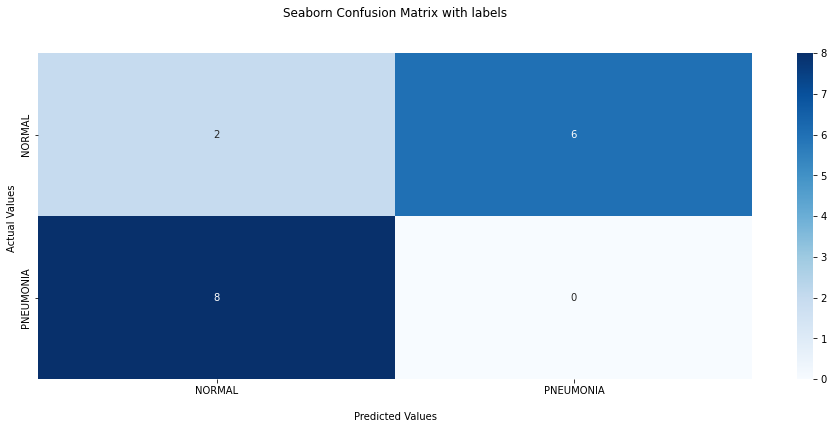

In [ ]:
import seaborn as sns

ax = sns.heatmap(conf_mat2, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
CLASSES = ['NORMAL', 'PNEUMONIA']

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(CLASSES)
ax.yaxis.set_ticklabels(CLASSES)

## Display the visualization of the Confusion Matrix.
plt.show()

### Conclusion:

* For the first challenger model, we changed the network depth and arch. - `We found that it gave identical performance`
* For the second challengaer model, we changed the optimizer to SGD. - `We found that it gave worse results and increased misclassification rate`

### Also, as an expected outcome, we can conclude that simple neural networks cannot be utlised for learning unstructured data such as images, we need a better learning machine `(Convolutional Neural Nets)` to achieve sufficient performance.